So here, we want to create an equivalent to the dfoil_sim set of functions for use with msprime

In [1]:
import msprime
from __future__ import print_function, unicode_literals
import sys
import os
import argparse
import subprocess
from random import sample
import numpy as np
import time
import sklearn
from sklearn import preprocessing

The dfoil simulation functions are adapted below.

In [3]:
def generate_argparser():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("outputfile", type=os.path.abspath,
                        help=" output site count filename")
    parser.add_argument("--msfile", help="""use pre-computed ms output
                                             file instead of running ms.""")
    parser.add_argument("--nloci", type=int, default=100,
                        help="number of windows to simulate")
    parser.add_argument("--window", type=int, default=100000,
                        help="length (bp) of windows")
    parser.add_argument("--popsize", type=int, default=1e6,
                        help="Ne, effective population size (default=1e6)")
    parser.add_argument("--mu", type=float, default=7e-9,
                        help="""per site per generation mutation rate
                                (default=7e-9)""")
    parser.add_argument("--mrate", type=float, default=5e-4,
                        help="""per individual per generation migration
                                rate (default=5e-4)""")
    parser.add_argument("--msource", type=int,
                        help="1-based index of migration source population")
    parser.add_argument("--mdest", type=int,
                        help="1-based index of migration recipient population")
    parser.add_argument("--mtimes", type=float, nargs=2,
                        help="time bounds for the migration period")
    parser.add_argument("--coaltimes", type=float, nargs=4,
                        default=(3, 2, 1, 1),
                        help="""coalescent times in 4Ne units""")
    parser.add_argument("--recomb", type=float, default=0.,
                        help="""per site per generation recombination rate
                                (default=0)""")
    parser.add_argument("--rho", type=float,
                        help="""specific rho = 4*Ne*mu instead of using
                                --recomb""")
    parser.add_argument("--mspath", default="ms",
                        help="""path to ms executable""")
    parser.add_argument("--nconverge", type=int, default=0,
                        help="number of convergent sites per window")
    parser.add_argument("--quiet", action='store_true',
                        help='suppress screen output')
    parser.add_argument("--version", action="version", version="2017-06-14",
                        help="display version information and quit")
    return parser

In [28]:
def which(program):
    def is_exe(fpath):
        return os.path.isfile(fpath) and os.access(fpath, os.X_OK)
    fpath, fname = os.path.split(program)
    if fpath:
        if is_exe(program):
            return program
    else:
        for path in os.environ["PATH"].split(os.pathsep):
            path = path.strip('"')
            exe_file = os.path.join(path, program)
            if is_exe(exe_file):
                return exe_file
    return None

In [32]:
def main(arguments=None):
    """Main method"""
    arguments = arguments if arguments is not None else ['sim.genetrees']
    parser = generate_argparser()
    args = parser.parse_args(args=arguments)
    if args.rho and args.recomb:
        raise RuntimeError("Cannot use both --rho and --recomb")
    if args.mtimes:
        args.mtime_older = min(args.mtimes)
        args.mtime_newer = max(args.mtimes)
    if not args.msfile:
        if which(args.mspath) is None:
            raise RuntimeError("Cannot find 'ms' at path='{}', "
                               "is it installed?".format(
                                    args.mspath))
    # BEGIN RUNS
    msfilepath = args.msfile and args.msfile or run_ms(vars(args))
    #aligns = process_msfile(msfilepath, args.window)
    #process_aligns(aligns, vars(args))
    return ''

In [49]:
main(['test','--nloci','100','--recomb','1e-7'])

theta=0.028
rho=40000.0
ms 5 100 -t 2800.0 -I 5 1 1 1 1 1 -r 40000.0 100000 -ej 1 2 1 -ej 1 4 3 -ej 2 3 1 -ej 3 5 1 > /Users/pmckenz1/Dropbox/projects/introgression/test.ms.tmp


KeyboardInterrupt: 

In [ ]:
python dfoil_sim.py introg_sim_1_3.sites --nloci 100 --recomb 1e-7 --window 10000 --coaltimes 1.5 1.2 0.5 1 --mu 7e-8 --msource 1 --mdest 3 --mtimes 0.2 0.25 --mrate 5e-5


In [38]:
def run_ms(params):
    """Runs the ms program to simulate sequence evolutions
        Arguments:
            params: dict from main args
    """
    nspec = 5
    nloci = params['nloci']
    coaltimes = params['coaltimes']
    theta = 4 * params['mu'] * params['popsize']
    if not params['quiet']:
        print("theta={}".format(theta))
    theta = theta * params['window']
    cmd = ['ms', str(nspec), str(nloci), # this is where can adjust ms vs mspms
           "-t", str(theta), "-I", str(nspec)] + ['1'] * nspec
    if params['recomb'] or params['rho']:
        if params['recomb']:
            rho = 4 * params['popsize'] * params['recomb'] * params['window']
        elif params['rho']:
            rho = params['window'] * params['rho']
        cmd.extend(["-r", str(rho), str(params['window'])])
        if not params['quiet']:
            print("rho={}".format(rho))
    cmd.extend(['-ej', str(coaltimes[2]), '2', '1'])
    cmd.extend(['-ej', str(coaltimes[3]), '4', '3'])
    cmd.extend(['-ej', str(coaltimes[1]), '3', '1'])
    cmd.extend(['-ej', str(coaltimes[0]), '5', '1'])
    if params['msource']:
        migration = params['mrate'] * 4 * params['popsize']
        cmd.extend(["-em", str(params['mtime_newer']), str(params['mdest']),
                    str(params['msource']), str(params['mrate'])])
        cmd.extend(["-eM", str(params['mtime_older']), '0'])
        if not params['quiet']:
            print("m={} {}>{} @{}-{}".format(
                migration, params['msource'], params['mdest'],
                params['mtime_newer'], params['mtime_older']))
    cmd.append("> {}.ms.tmp".format(params['outputfile']))
    cmd = ' '.join(cmd)
    if not params['quiet']:
        print(cmd)
    with open('{}.ms.log'.format(params['outputfile']), 'w') as tmpfile:
        process = subprocess.Popen(
            cmd, shell=True, stdout=tmpfile, stderr=tmpfile)
        process.communicate()
    if not params['quiet']:
        print("ms done")
    return '{}.ms.tmp'.format(params['outputfile'])

Here's my actual implementation:

In [166]:
length = 1
Ne = 1000000.
mutation_rate = 7e-8
num_replicates = 100000
recombination_rate = 0

population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]
                            #msprime.PopulationConfiguration(sample_size=1,initial_size=200000)]
#migration_matrix = [[0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.]]
migration_matrix = [[0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],]
demographic_events = [msprime.MigrationRateChange(time=.5*4*Ne,rate=5e-6*4*Ne,matrix_index=[0,2]),
                     msprime.MigrationRateChange(time=.55*4*Ne,rate=0),
                     msprime.MassMigration(destination=1,source=0,time=1.0*4*Ne,proportion=1),
                     msprime.MassMigration(destination=3, source=2,time=1.0*4*Ne,proportion=1),
                     msprime.MassMigration(destination=3, source=1,time=1.2*4*Ne,proportion=1),
                     msprime.MassMigration(destination=4, source=3,time=1.5*4*Ne,proportion=1)
                     ]

In [230]:
length = 1
Ne = 1000000.
mutation_rate = 7e-8
num_replicates = 100000
recombination_rate = 0

population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]
                            #msprime.PopulationConfiguration(sample_size=1,initial_size=200000)]
#migration_matrix = [[0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.],
#                    [0.,0.,0.,0.,0.]]
migration_matrix = [[0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],]
demographic_events = [msprime.MigrationRateChange(time=.5*4*Ne,rate=5e-5,matrix_index=[0,2]),
                     msprime.MigrationRateChange(time=.55*4*Ne,rate=0),
                     msprime.MassMigration(destination=1,source=0,time=3.0*4*Ne,proportion=1),
                     #msprime.MassMigration(destination=1, source=2,time=1.0*4*Ne,proportion=1),
                     msprime.MassMigration(destination=1, source=2,time=3.2*4*Ne,proportion=1),
                     msprime.MassMigration(destination=1, source=3,time=3.5*4*Ne,proportion=1)
                     ]

In [304]:
# select migration rate (between 0 and .3 with tall left tail)
mig_rate = np.random.gamma(shape = 1, scale=.01,size = 1000000)
# select window width 
win_width = np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = np.random.uniform(0.1, 0.9, size = 1000000)

In [303]:
np.random.gamma(shape = 1, scale=.01,size = 1000000)

array([ 0.00088062,  0.00182576,  0.01691687, ...,  0.00690777,
        0.00624452,  0.00160187])

In [231]:
simulation = msprime.simulate(length=length,
                 Ne=Ne,
                 mutation_rate=mutation_rate,
                 num_replicates=num_replicates,
                 #recombination_rate=recombination_rate,
                 population_configurations=population_configurations,
                migration_matrix = migration_matrix,         
                 demographic_events=demographic_events)
                

In [232]:
geno = np.empty(shape = [0,4])

for i in simulation:
    currentrep = simulation.next()
    currentgeno = currentrep.genotype_matrix()
    geno = np.concatenate((geno, currentgeno.astype(int)),axis = 0)

In [233]:
geno= geno.astype(int).astype(str)

In [234]:
geno_conv = [''.join(i) for i in geno]

In [235]:
np.unique(geno_conv)

array([u'0001', u'0010', u'0011', u'0100', u'0101', u'0110', u'0111',
       u'1000', u'1001', u'1010', u'1011', u'1100', u'1101', u'1110'],
      dtype='<U4')

In [236]:
for genotype in np.unique(geno_conv):
    tally = 0
    for instance in geno_conv:
        tally = tally + int(instance == genotype)
    print("Number of genotypes matching " + str(genotype) + " = " + str(tally))

Number of genotypes matching 0001 = 50918
Number of genotypes matching 0010 = 46335
Number of genotypes matching 0011 = 44
Number of genotypes matching 0100 = 43683
Number of genotypes matching 0101 = 5
Number of genotypes matching 0110 = 96
Number of genotypes matching 0111 = 4
Number of genotypes matching 1000 = 43643
Number of genotypes matching 1001 = 6
Number of genotypes matching 1010 = 110
Number of genotypes matching 1011 = 5
Number of genotypes matching 1100 = 2884
Number of genotypes matching 1101 = 45
Number of genotypes matching 1110 = 4220


In [214]:
#0110 and 1010
(115.-103.)/(115.+103.)

0.05504587155963303

In [229]:
#0110 and 1010
(27.-23798.)/(27.+23798.)

-0.9977334732423925

In [ ]:
t0 = time.time()

t1 = time.time()

total_n = t1-t0

Training set:

In [3]:
# select migration rate (between 0 and .3 with tall left tail)
#mig_rate = np.random.binomial
length_mig_rate = 1000000
mig_rate = np.append(np.random.gamma(shape = 1, scale=.01,size = int(length_mig_rate/2.)),[0]*(int(length_mig_rate/2.)))
np.random.shuffle(mig_rate)

np.random.gamma(shape = 1, scale=.01,size = 1000000)
# select window width 
win_width = [.05]*1000000 #np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*1000000 #np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
num_reps_list = [10000]*1000000 #(5000+np.random.randint(1,15000,1000000))*2

In [731]:
genotypes= ['0000','1000','1100','1110','1111','1011','1010','1101',
 '0111','0011','0010','0001','0100','0110','1001']
counts = np.empty(shape = [0,len(genotypes)],dtype=int)
for sample in range(1000000):
    length = 1
    Ne = 1000000.
    mutation_rate = 7e-8
    num_replicates = num_reps_list[sample]
    recombination_rate = 0
    population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]
                                #msprime.PopulationConfiguration(sample_size=1,initial_size=200000)]
    #migration_matrix = [[0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.]]
    migration_matrix = [[0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],]
    demographic_events = [msprime.MigrationRateChange(time=0,rate=0),
                         msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,rate=mig_rate[sample],matrix_index=[0,2]),
                         msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,rate=0),
                         msprime.MassMigration(destination=1,source=0,time=1.0*4*Ne,proportion=1),
                         #msprime.MassMigration(destination=1, source=2,time=1.0*4*Ne,proportion=1),
                         msprime.MassMigration(destination=1, source=2,time=1.2*4*Ne,proportion=1),
                         msprime.MassMigration(destination=1, source=3,time=1.5*4*Ne,proportion=1)
                         ]
    simulation = msprime.simulate(length=length,
                     Ne=Ne,
                     mutation_rate=mutation_rate,
                     num_replicates=num_replicates,
                     #recombination_rate=recombination_rate,
                     population_configurations=population_configurations,
                    migration_matrix = migration_matrix,         
                     demographic_events=demographic_events)
    geno = np.empty(shape = [0,4],dtype=int)
    for i in simulation:
        currentrep = simulation.next()
        currentgeno = currentrep.genotype_matrix()
        geno = np.concatenate((geno, currentgeno))
    geno= geno.astype(str)
    geno_conv = [''.join(i) for i in geno]
    tallies = np.empty(shape = [0,0])
    for genotype in np.unique(genotypes):
        tally = 0
        for instance in geno_conv:
            tally = tally + int(instance == genotype)
        if tally:
            tallies = np.append(tallies,tally)
        else:
            tallies = np.append(tallies,0)
    counts = np.vstack([counts, tallies.astype(int)])
    print("Done with number " + str(sample) + "!")

Done with number 0!
Done with number 1!
Done with number 2!
Done with number 3!
Done with number 4!


KeyboardInterrupt: 

In [4]:
genotypes= ['0000','1000','1100','1110','1111','1011','1010','1101',
 '0111','0011','0010','0001','0100','0110','1001']
counts = np.empty(shape = [0,len(genotypes)],dtype=int)
for sample in range(1000000):
    length = 10000
    Ne = 1000000.
    mutation_rate = 7e-8
    num_replicates = 1
    recombination_rate = 1e-8
    population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]
                                #msprime.PopulationConfiguration(sample_size=1,initial_size=200000)]
    #migration_matrix = [[0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.],
    #                    [0.,0.,0.,0.,0.]]
    migration_matrix = [[0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],]
    demographic_events = [msprime.MigrationRateChange(time=0,rate=0),
                         msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,rate=mig_rate[sample],matrix_index=[0,2]),
                         msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,rate=0),
                         msprime.MassMigration(destination=1,source=0,time=1.0*4*Ne,proportion=1),
                         #msprime.MassMigration(destination=1, source=2,time=1.0*4*Ne,proportion=1),
                         msprime.MassMigration(destination=1, source=2,time=1.2*4*Ne,proportion=1),
                         msprime.MassMigration(destination=1, source=3,time=1.5*4*Ne,proportion=1)
                         ]
    simulation = msprime.simulate(length=length,
                     Ne=Ne,
                     mutation_rate=mutation_rate,
                     num_replicates=num_replicates,
                     #recombination_rate=recombination_rate,
                     population_configurations=population_configurations,
                    migration_matrix = migration_matrix,         
                     demographic_events=demographic_events)
    geno = simulation.next().genotype_matrix()
    geno= geno.astype(str)
    geno_conv = [''.join(i) for i in geno]
    tallies = np.empty(shape = [0,0])
    for genotype in np.unique(genotypes):
        tally = 0
        for instance in geno_conv:
            tally = tally + int(instance == genotype)
        if tally:
            tallies = np.append(tallies,tally)
        else:
            tallies = np.append(tallies,0)
    counts = np.vstack([counts, tallies.astype(int)])
    print("Done with number " + str(sample))

Done with number 0
Done with number 1
Done with number 2
Done with number 3
Done with number 4
Done with number 5
Done with number 6
Done with number 7
Done with number 8
Done with number 9
Done with number 10
Done with number 11
Done with number 12
Done with number 13
Done with number 14
Done with number 15
Done with number 16
Done with number 17
Done with number 18
Done with number 19
Done with number 20
Done with number 21
Done with number 22
Done with number 23
Done with number 24
Done with number 25
Done with number 26
Done with number 27
Done with number 28
Done with number 29
Done with number 30
Done with number 31
Done with number 32
Done with number 33
Done with number 34
Done with number 35
Done with number 36
Done with number 37
Done with number 38
Done with number 39
Done with number 40
Done with number 41
Done with number 42
Done with number 43
Done with number 44
Done with number 45
Done with number 46
Done with number 47
Done with number 48
Done with number 49
Done with 

Done with number 395
Done with number 396
Done with number 397
Done with number 398
Done with number 399
Done with number 400
Done with number 401
Done with number 402
Done with number 403
Done with number 404
Done with number 405
Done with number 406
Done with number 407
Done with number 408
Done with number 409
Done with number 410
Done with number 411
Done with number 412
Done with number 413
Done with number 414
Done with number 415
Done with number 416
Done with number 417
Done with number 418
Done with number 419
Done with number 420
Done with number 421
Done with number 422
Done with number 423
Done with number 424
Done with number 425
Done with number 426
Done with number 427
Done with number 428
Done with number 429
Done with number 430
Done with number 431
Done with number 432
Done with number 433
Done with number 434
Done with number 435
Done with number 436
Done with number 437
Done with number 438
Done with number 439
Done with number 440
Done with number 441
Done with num

Done with number 787
Done with number 788
Done with number 789
Done with number 790
Done with number 791
Done with number 792
Done with number 793
Done with number 794
Done with number 795
Done with number 796
Done with number 797
Done with number 798
Done with number 799
Done with number 800
Done with number 801
Done with number 802
Done with number 803
Done with number 804
Done with number 805
Done with number 806
Done with number 807
Done with number 808
Done with number 809
Done with number 810
Done with number 811
Done with number 812
Done with number 813
Done with number 814
Done with number 815
Done with number 816
Done with number 817
Done with number 818
Done with number 819
Done with number 820
Done with number 821
Done with number 822
Done with number 823
Done with number 824
Done with number 825
Done with number 826
Done with number 827
Done with number 828
Done with number 829
Done with number 830
Done with number 831
Done with number 832
Done with number 833
Done with num

Done with number 1171
Done with number 1172
Done with number 1173
Done with number 1174
Done with number 1175
Done with number 1176
Done with number 1177
Done with number 1178
Done with number 1179
Done with number 1180
Done with number 1181
Done with number 1182
Done with number 1183
Done with number 1184
Done with number 1185
Done with number 1186
Done with number 1187
Done with number 1188
Done with number 1189
Done with number 1190
Done with number 1191
Done with number 1192
Done with number 1193
Done with number 1194
Done with number 1195
Done with number 1196
Done with number 1197
Done with number 1198
Done with number 1199
Done with number 1200
Done with number 1201
Done with number 1202
Done with number 1203
Done with number 1204
Done with number 1205
Done with number 1206
Done with number 1207
Done with number 1208
Done with number 1209
Done with number 1210
Done with number 1211
Done with number 1212
Done with number 1213
Done with number 1214
Done with number 1215
Done with 

Done with number 1543
Done with number 1544
Done with number 1545
Done with number 1546
Done with number 1547
Done with number 1548
Done with number 1549
Done with number 1550
Done with number 1551
Done with number 1552
Done with number 1553
Done with number 1554
Done with number 1555
Done with number 1556
Done with number 1557
Done with number 1558
Done with number 1559
Done with number 1560
Done with number 1561
Done with number 1562
Done with number 1563
Done with number 1564
Done with number 1565
Done with number 1566
Done with number 1567
Done with number 1568
Done with number 1569
Done with number 1570
Done with number 1571
Done with number 1572
Done with number 1573
Done with number 1574
Done with number 1575
Done with number 1576
Done with number 1577
Done with number 1578
Done with number 1579
Done with number 1580
Done with number 1581
Done with number 1582
Done with number 1583
Done with number 1584
Done with number 1585
Done with number 1586
Done with number 1587
Done with 

Done with number 1915
Done with number 1916
Done with number 1917
Done with number 1918
Done with number 1919
Done with number 1920
Done with number 1921
Done with number 1922
Done with number 1923
Done with number 1924
Done with number 1925
Done with number 1926
Done with number 1927
Done with number 1928
Done with number 1929
Done with number 1930
Done with number 1931
Done with number 1932
Done with number 1933
Done with number 1934
Done with number 1935
Done with number 1936
Done with number 1937
Done with number 1938
Done with number 1939
Done with number 1940
Done with number 1941
Done with number 1942
Done with number 1943
Done with number 1944
Done with number 1945
Done with number 1946
Done with number 1947
Done with number 1948
Done with number 1949
Done with number 1950
Done with number 1951
Done with number 1952
Done with number 1953
Done with number 1954
Done with number 1955
Done with number 1956
Done with number 1957
Done with number 1958
Done with number 1959
Done with 

Done with number 2289
Done with number 2290
Done with number 2291
Done with number 2292
Done with number 2293
Done with number 2294
Done with number 2295
Done with number 2296
Done with number 2297
Done with number 2298
Done with number 2299
Done with number 2300
Done with number 2301
Done with number 2302
Done with number 2303
Done with number 2304
Done with number 2305
Done with number 2306
Done with number 2307
Done with number 2308
Done with number 2309
Done with number 2310
Done with number 2311
Done with number 2312
Done with number 2313
Done with number 2314
Done with number 2315
Done with number 2316
Done with number 2317
Done with number 2318
Done with number 2319
Done with number 2320
Done with number 2321
Done with number 2322
Done with number 2323
Done with number 2324
Done with number 2325
Done with number 2326
Done with number 2327
Done with number 2328
Done with number 2329
Done with number 2330
Done with number 2331
Done with number 2332
Done with number 2333
Done with 

Done with number 2662
Done with number 2663
Done with number 2664
Done with number 2665
Done with number 2666
Done with number 2667
Done with number 2668
Done with number 2669
Done with number 2670
Done with number 2671
Done with number 2672
Done with number 2673
Done with number 2674
Done with number 2675
Done with number 2676
Done with number 2677
Done with number 2678
Done with number 2679
Done with number 2680
Done with number 2681
Done with number 2682
Done with number 2683
Done with number 2684
Done with number 2685
Done with number 2686
Done with number 2687
Done with number 2688
Done with number 2689
Done with number 2690
Done with number 2691
Done with number 2692
Done with number 2693
Done with number 2694
Done with number 2695
Done with number 2696
Done with number 2697
Done with number 2698
Done with number 2699
Done with number 2700
Done with number 2701
Done with number 2702
Done with number 2703
Done with number 2704
Done with number 2705
Done with number 2706
Done with 

Done with number 3035
Done with number 3036
Done with number 3037
Done with number 3038
Done with number 3039
Done with number 3040
Done with number 3041
Done with number 3042
Done with number 3043
Done with number 3044
Done with number 3045
Done with number 3046
Done with number 3047
Done with number 3048
Done with number 3049
Done with number 3050
Done with number 3051
Done with number 3052
Done with number 3053
Done with number 3054
Done with number 3055
Done with number 3056
Done with number 3057
Done with number 3058
Done with number 3059
Done with number 3060
Done with number 3061
Done with number 3062
Done with number 3063
Done with number 3064
Done with number 3065
Done with number 3066
Done with number 3067
Done with number 3068
Done with number 3069
Done with number 3070
Done with number 3071
Done with number 3072
Done with number 3073
Done with number 3074
Done with number 3075
Done with number 3076
Done with number 3077
Done with number 3078
Done with number 3079
Done with 

Done with number 3408
Done with number 3409
Done with number 3410
Done with number 3411
Done with number 3412
Done with number 3413
Done with number 3414
Done with number 3415
Done with number 3416
Done with number 3417
Done with number 3418
Done with number 3419
Done with number 3420
Done with number 3421
Done with number 3422
Done with number 3423
Done with number 3424
Done with number 3425
Done with number 3426
Done with number 3427
Done with number 3428
Done with number 3429
Done with number 3430
Done with number 3431
Done with number 3432
Done with number 3433
Done with number 3434
Done with number 3435
Done with number 3436
Done with number 3437
Done with number 3438
Done with number 3439
Done with number 3440
Done with number 3441
Done with number 3442
Done with number 3443
Done with number 3444
Done with number 3445
Done with number 3446
Done with number 3447
Done with number 3448
Done with number 3449
Done with number 3450
Done with number 3451
Done with number 3452
Done with 

KeyboardInterrupt: 

In [5]:
norm=preprocessing.Normalizer(copy=False,norm='l2')
trans_norm = norm.transform(counts)

In [6]:
len(trans_norm)

3509

In [7]:
int_mig_rate=(mig_rate > 0).astype(int)

In [8]:
testset = np.empty(shape=[0,16])
for i in range(3000,3500):
    testset=np.vstack([testset,np.append(mig_rate[i],trans_norm[i])])

In [9]:
testset[:,0] = (testset[:,0] > 0).astype(int)

In [744]:
testset

array([[ 0.        ,  0.        ,  0.26654954, ...,  0.        ,
         0.02208697,  0.        ],
       [ 1.        ,  0.        ,  0.31388024, ...,  0.        ,
         0.07054344,  0.        ],
       [ 1.        ,  0.        ,  0.30774658, ...,  0.        ,
         0.03591082,  0.        ],
       ..., 
       [ 1.        ,  0.        ,  0.33134221, ...,  0.        ,
         0.0820439 ,  0.        ],
       [ 0.        ,  0.        ,  0.27548353, ...,  0.        ,
         0.04286461,  0.        ],
       [ 1.        ,  0.        ,  0.30369616, ...,  0.        ,
         0.04300058,  0.        ]])

In [10]:
sorted_test= testset[testset[:,0].argsort()]

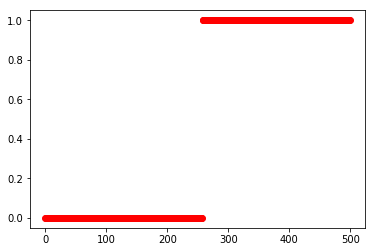

In [11]:
import matplotlib.pyplot as plt
plt.plot(sorted_test[:,0], 'ro')
plt.show()

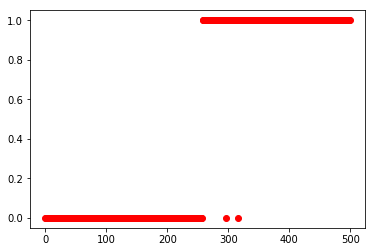

In [33]:
plt.plot(clf.predict(sorted_test[:,1:16]),'ro')
plt.show()

In [708]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(random_state=0,
                             bootstrap = True, 
                             max_depth=2,
                             n_estimators=10)
regr.fit(trans_norm[0:1000], mig_rate[0:1000])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [699]:
from sklearn import svm
X = trans_norm[0:1000]
y = mig_rate[0:1000]
clf = svm.SVR(C=10,epsilon=.0000001)
clf.fit(X, y) 

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1e-07, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [32]:
from sklearn import svm
X = trans_norm[0:3000]
y = int_mig_rate[0:3000]
clf = svm.SVC(C=10)
clf.fit(X, y)  

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)